In [1]:
import os, sys
import random
import pandas as pd
import numpy as np
import numpy
#import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import cv2
import pandas as pd
import math
import time

from tqdm import tqdm

from torchvision import datasets, transforms
from transformers import GLPNForDepthEstimation, GLPNFeatureExtractor
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from PIL import Image
from transformers import GLPNForDepthEstimation, GLPNFeatureExtractor

# 설명
https://www.changjiangcai.com/studynotes/2020-05-16-Virtual-KITTI-2-Dataset/  

# 다운
https://europe.naverlabs.com/research/computer-vision/proxy-virtual-worlds-vkitti-2/  
-> rgb파일 다운 받기

# 폴더와 압축 파일이 안 풀려있다면 실행

In [2]:
#os.makedirs('./VKITTI', exist_ok=True)
#os.makedirs('./VKITTI_txt', exist_ok=True)

In [3]:
# 압축풀기1
#tar = tarfile.open("vkitti_2.0.3_rgb.tar")
#tar.extractall('./VKITTI/')
#tar.close()

In [4]:
# 압축풀기2
#tar = tarfile.open("vkitti_2.0.3_textgt.tar.gz")
#tar.extractall('./VKITTI_txt/')
#tar.close()

# 데이터 확인 및 Preprocessing

In [5]:
scene1_clone = os.listdir('./VKITTI/Scene01/clone/frames/rgb/Camera_1/')
scene1_fog = os.listdir('./VKITTI/Scene01/fog/frames/rgb/Camera_1/')

print(len(scene1_clone)) # 447개
print(len(scene1_fog))

447
447


In [6]:
447//6

74

In [7]:
# Scene1에 대해서 일단 실행
scene1_clone = os.listdir('./VKITTI/Scene01/clone/frames/rgb/Camera_1/')
scene1_fog = os.listdir('./VKITTI/Scene01/fog/frames/rgb/Camera_1/')
scene1_morning = os.listdir('./VKITTI/Scene01/morning/frames/rgb/Camera_1/')
scene1_overcast = os.listdir('./VKITTI/Scene01/overcast/frames/rgb/Camera_1/')
scene1_rain = os.listdir('./VKITTI/Scene01/rain/frames/rgb/Camera_1/')
scene1_sunset = os.listdir('./VKITTI/Scene01/sunset/frames/rgb/Camera_1/')

print(len(scene1_clone))
print(len(scene1_fog))
print(len(scene1_morning))
print(len(scene1_overcast))
print(len(scene1_rain))
print(len(scene1_sunset))

447
447
447
447
447
447


In [8]:
scene1_clone

['rgb_00000.jpg',
 'rgb_00001.jpg',
 'rgb_00002.jpg',
 'rgb_00003.jpg',
 'rgb_00004.jpg',
 'rgb_00005.jpg',
 'rgb_00006.jpg',
 'rgb_00007.jpg',
 'rgb_00008.jpg',
 'rgb_00009.jpg',
 'rgb_00010.jpg',
 'rgb_00011.jpg',
 'rgb_00012.jpg',
 'rgb_00013.jpg',
 'rgb_00014.jpg',
 'rgb_00015.jpg',
 'rgb_00016.jpg',
 'rgb_00017.jpg',
 'rgb_00018.jpg',
 'rgb_00019.jpg',
 'rgb_00020.jpg',
 'rgb_00021.jpg',
 'rgb_00022.jpg',
 'rgb_00023.jpg',
 'rgb_00024.jpg',
 'rgb_00025.jpg',
 'rgb_00026.jpg',
 'rgb_00027.jpg',
 'rgb_00028.jpg',
 'rgb_00029.jpg',
 'rgb_00030.jpg',
 'rgb_00031.jpg',
 'rgb_00032.jpg',
 'rgb_00033.jpg',
 'rgb_00034.jpg',
 'rgb_00035.jpg',
 'rgb_00036.jpg',
 'rgb_00037.jpg',
 'rgb_00038.jpg',
 'rgb_00039.jpg',
 'rgb_00040.jpg',
 'rgb_00041.jpg',
 'rgb_00042.jpg',
 'rgb_00043.jpg',
 'rgb_00044.jpg',
 'rgb_00045.jpg',
 'rgb_00046.jpg',
 'rgb_00047.jpg',
 'rgb_00048.jpg',
 'rgb_00049.jpg',
 'rgb_00050.jpg',
 'rgb_00051.jpg',
 'rgb_00052.jpg',
 'rgb_00053.jpg',
 'rgb_00054.jpg',
 'rgb_0005

# 일단 Clone 데이터에 대해서 먼저 데이터 정리해보기

In [9]:
# 데이터 뽑아내기
scene1_clone_bbox = pd.read_csv('./VKITTI_txt/Scene01/clone/bbox.txt', delimiter=' ')
scene1_clone_info = pd.read_csv('./VKITTI_txt/Scene01/clone/info.txt', delimiter=' ')
scene1_clone_pose = pd.read_csv('./VKITTI_txt/Scene01/clone/pose.txt', delimiter=' ')

In [10]:
# For example
# 좌표 뽑아내기
scene1_clone_bbox

,frame,cameraID,trackID,left,right,top,bottom,number_pixels,truncation_ratio,occupancy_ratio,isMoving
0,0,0,0,774,1241,169,374,75554,0.077260,0.789199,False
1,0,0,1,722,866,186,281,5433,0.000000,0.397149,False
2,0,0,2,696,771,185,246,2109,0.000000,0.460984,False
3,0,0,3,394,474,201,256,2534,0.000000,0.575909,False
4,0,0,4,509,542,195,220,459,0.000000,0.556364,False
...,...,...,...,...,...,...,...,...,...,...,...
13895,423,1,86,0,194,212,374,22571,0.677169,0.718181,True
13896,424,0,86,0,205,214,374,25209,0.725561,0.768567,True
13897,424,1,86,0,156,214,374,17239,0.833873,0.690665,True
13898,425,0,86,0,165,218,374,17742,0.869183,0.689277,True


In [11]:
# label 뽑아내기
scene1_clone_info

,trackID,label,model,color
0,0,Car,Sedan4Door,Black
1,1,Car,Hatchback,Black
2,2,Car,Hybrid,Black
3,3,Car,Hatchback,Red
4,4,Car,Hatchback,Silver
...,...,...,...,...
88,81,Car,Hatchback,Grey
89,86,Car,Sedan4Door,White
90,83,Car,Hatchback,Black
91,84,Car,Sedan4Door,Black


In [12]:
scene1_clone_info['label'].unique() # 3개

array(['Car', 'Van', 'Truck'], dtype=object)

In [13]:
len(scene1_clone_bbox)

13900

In [14]:
# zloc와 angle 뽑아내기
scene1_clone_pose

,frame,cameraID,trackID,alpha,width,height,length,world_space_X,world_space_Y,world_space_Z,rotation_world_space_y,rotation_world_space_x,rotation_world_space_z,camera_space_X,camera_space_Y,camera_space_Z,rotation_camera_space_y,rotation_camera_space_x,rotation_camera_space_z
0,0,0,0,-1.996793,1.850000,1.509920,4.930564,6.371316,-111,-5.044228,0.269431,0,0,2.904048,1.434100,6.406569,-1.571205,0.001541,-0.072243
1,0,0,1,-1.796513,1.612032,1.404795,3.772344,12.851120,-111,-6.945244,0.268901,0,0,3.008632,1.415930,13.158640,-1.571733,0.001502,-0.072243
2,0,0,2,-1.654057,1.567278,1.413269,3.158158,18.775960,-111,-8.529280,0.338807,0,0,2.956056,1.410106,19.291350,-1.502008,0.006540,-0.071963
3,0,0,3,1.832166,1.555003,1.527328,3.576751,25.473800,-111,-1.092491,-2.856606,0,0,-5.973762,2.049313,23.765340,1.585904,-0.002663,0.072210
4,0,0,4,1.688990,1.540477,1.417371,3.504343,47.346200,-111,-7.073209,-2.882920,0,0,-6.039978,2.018503,46.440570,1.559658,-0.000764,0.072255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13895,423,1,86,2.240986,1.867924,1.481739,4.736537,242.987500,-111,82.818670,2.042961,0,0,-5.912372,1.793955,6.390986,1.494469,-0.003960,0.034806
13896,424,0,86,2.242229,1.867924,1.481739,4.736537,242.638400,-111,82.139500,2.033088,0,0,-5.315776,1.795443,5.618875,1.484543,-0.003809,0.034794
13897,424,1,86,2.289963,1.867924,1.481739,4.736537,242.638400,-111,82.139500,2.033088,0,0,-5.848503,1.795443,5.618877,1.484543,-0.003809,0.034794
13898,425,0,86,2.300111,1.867924,1.481739,4.736537,242.288500,-111,81.456380,2.023132,0,0,-5.251845,1.798375,4.846781,1.474623,-0.003497,0.034843


#### 전처리

In [15]:
# 데이터 feature 추출

# bbox 데이터에서 xmin, ymin, xmax, ymax value 뽑아내기
# camera_ID == 1만 사용
scene1_clone_bbox.rename(columns={'left':'xmin', 'right':'xmax', 'top':'ymin', 'bottom':'ymax'}, inplace=True)
scene1_clone_bbox = scene1_clone_bbox[scene1_clone_bbox['cameraID']==1][['xmin','ymin','xmax','ymax','trackID','frame']]

filename = [scene1_clone[fr] for fr in scene1_clone_bbox['frame'].values]
scene1_clone_bbox.drop('frame', axis=1, inplace=True)

# trackID에 맞는 label을 대응
label_list = [scene1_clone_info[scene1_clone_info['trackID']==trackID]['label'].values[0] \
              for trackID in scene1_clone_bbox['trackID'].values] 
scene1_clone_bbox.drop('trackID', axis=1, inplace=True)

scene1_clone_pose.rename(columns={'camera_space_Z':'zloc', 'alpha':'angle'}, inplace=True)
scene1_clone_pose = scene1_clone_pose[scene1_clone_pose['cameraID']==1][['angle','zloc']]

scene1_clone_bbox.reset_index(inplace=True)
scene1_clone_pose.reset_index(inplace=True)
scene1_clone_bbox.drop('index', axis=1, inplace=True)
scene1_clone_pose.drop('index', axis=1, inplace=True)

In [16]:
print(len(scene1_clone_bbox))
print(len(label_list))
print(len(scene1_clone_pose))
print(len(filename))

6953
6953
6953
6953


In [17]:
scene1_clone_bbox

,xmin,ymin,xmax,ymax
0,730,167,1207,374
1,696,186,832,281
2,677,185,749,246
3,377,201,459,256
4,500,195,534,220
...,...,...,...,...
6948,0,208,252,374
6949,0,209,225,374
6950,0,212,194,374
6951,0,214,156,374


In [18]:
scene1_clone_pose

,angle,zloc
0,-1.925707,6.406569
1,-1.757717,13.158640
2,-1.626971,19.291350
3,1.853136,23.765340
4,1.700254,46.440570
...,...,...
6948,2.164934,7.935210
6949,2.199708,7.163083
6950,2.240986,6.390986
6951,2.289963,5.618877


In [19]:
# 데이터 병합하기
scene1_clone_data = pd.DataFrame({'filename':filename})
scene1_clone_data['class'] = label_list
scene1_clone_data = pd.concat([scene1_clone_data, scene1_clone_bbox], axis=1)
scene1_clone_data = pd.concat([scene1_clone_data, scene1_clone_pose], axis=1)
scene1_clone_data['weather'] = 'clone'
scene1_clone_data['class'].replace({'Car':'car', 'Van':'car', 'Truck':'truck'}, inplace=True)

In [20]:
set_filename = scene1_clone[:74]
#print(set_filename)
mask = [index for index in range(len(scene1_clone_data)) if scene1_clone_data['filename'].values[index] in set_filename]
scene1_clone_data = scene1_clone_data.iloc[mask]

In [21]:
scene1_clone_data

,filename,class,xmin,ymin,xmax,ymax,angle,zloc,weather
0,rgb_00000.jpg,car,730,167,1207,374,-1.925707,6.406569,clone
1,rgb_00000.jpg,car,696,186,832,281,-1.757717,13.158640,clone
2,rgb_00000.jpg,car,677,185,749,246,-1.626971,19.291350,clone
3,rgb_00000.jpg,car,377,201,459,256,1.853136,23.765340,clone
4,rgb_00000.jpg,car,500,195,534,220,1.700254,46.440570,clone
...,...,...,...,...,...,...,...,...,...
2755,rgb_00073.jpg,car,566,182,583,196,1.653908,87.712040,clone
2756,rgb_00073.jpg,car,640,179,657,194,-1.650888,81.490670,clone
2757,rgb_00073.jpg,car,640,179,656,193,-1.695424,86.925200,clone
2758,rgb_00073.jpg,car,571,183,585,195,1.632849,92.803830,clone


# 시각화

In [22]:
k = 70
img = Image.open(os.path.join('./VKITTI/Scene01/clone/frames/rgb/Camera_1/',scene1_clone_data['filename'][k]))
img_shape = cv2.imread(os.path.join('./VKITTI/Scene01/clone/frames/rgb/Camera_1/',scene1_clone_data['filename'][k])).shape

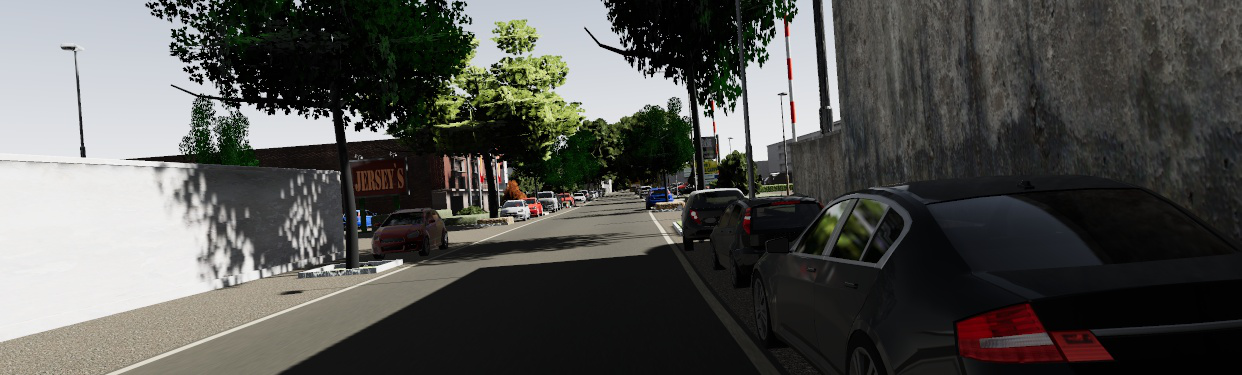

In [23]:
img

In [24]:
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# Preprocessing and bounding box
# standard PyTorch mean-std input image normalization
dpt_transform = transforms.Compose([
    #transforms.Resize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

# Detection
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)
    #img_shape = img.shape

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

detr_101 = torch.hub.load('facebookresearch/detr:main', 'detr_resnet101', pretrained=True) # Use resnet 101
detr_101.eval()
feature_extractor = GLPNFeatureExtractor.from_pretrained("vinvino02/glpn-kitti") # glpn-nyu2
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-kitti")
model.eval()

Using cache found in C:\Users\Admin/.cache\torch\hub\facebookresearch_detr_main


GLPNForDepthEstimation(
  (glpn): GLPNModel(
    (encoder): GLPNEncoder(
      (patch_embeddings): ModuleList(
        (0): GLPNOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): GLPNOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): GLPNOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): GLPNOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
      )
      (block): ModuleList(

In [25]:
scores, boxes = detect(img, detr_101, dpt_transform) # Detection

with torch.no_grad(): # Depth map
    pixel_values = feature_extractor(img, return_tensors="pt").pixel_values
    outputs = model(pixel_values) 
    predicted_depth = outputs.predicted_depth
    
    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
                        predicted_depth.unsqueeze(1),
                        size=img_shape[:2],
                        mode="bicubic",
                        align_corners=False,
                 )
    prediction = prediction.squeeze().cpu().numpy() # shape => (375, 1242)

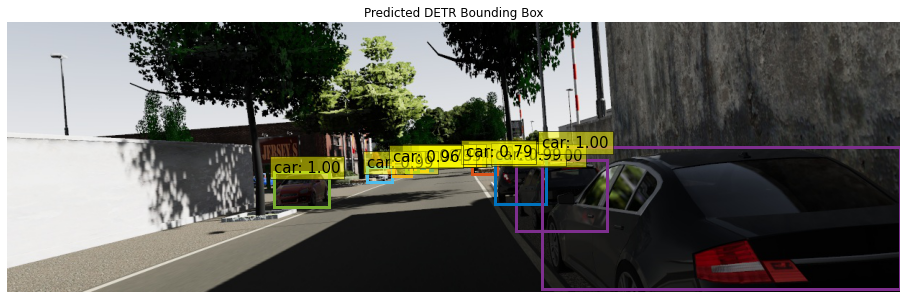

In [26]:
# 기존의 DETR 예측
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.title('Predicted DETR Bounding Box')
    plt.show()
    
plot_results(img, scores, boxes)

In [27]:
scene1_clone_data['filename'][k]

'rgb_00001.jpg'

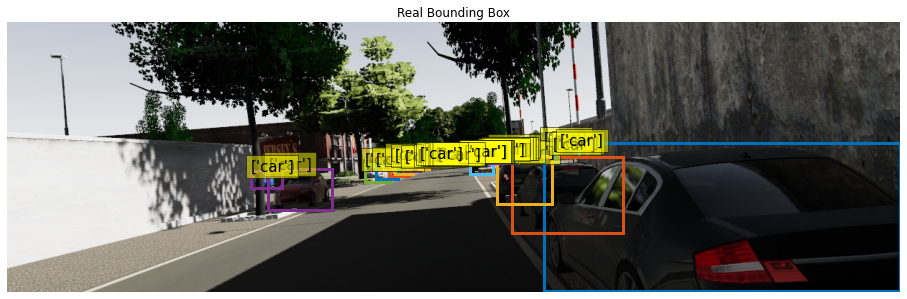

In [28]:
#mask = scene1_clone_data['filename'] == train_image_list[k]
mask = scene1_clone_data['filename'][k]
df_choose = scene1_clone_data.loc[scene1_clone_data['filename']==scene1_clone_data['filename'][k]]

class_list = df_choose[['class']].values
coordinates = df_choose[['xmin','ymin','xmax','ymax']].values

# 기존의 Real Data
def plot_results0(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        #cl = p.argmax()
        text = p
        ax.text(xmin, ymin, p, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.title('Real Bounding Box')
    plt.show()

plot_results0(img, class_list, coordinates)

In [29]:
df_choose

,filename,class,xmin,ymin,xmax,ymax,angle,zloc,weather
40,rgb_00001.jpg,car,746,167,1241,374,-1.995830,5.229192,clone
41,rgb_00001.jpg,car,702,187,856,293,-1.774960,11.981260,clone
42,rgb_00001.jpg,car,681,186,758,252,-1.634634,18.113990,clone
43,rgb_00001.jpg,car,363,203,451,261,1.866621,22.589040,clone
44,rgb_00001.jpg,car,497,197,532,222,1.703997,45.264300,clone
45,rgb_00001.jpg,car,644,185,675,210,-1.625290,48.820600,clone
46,rgb_00001.jpg,car,512,196,543,218,1.709208,50.837650,clone
47,rgb_00001.jpg,car,531,190,558,214,1.675393,59.145690,clone
48,rgb_00001.jpg,car,539,191,564,211,1.680149,65.775900,clone
49,rgb_00001.jpg,car,553,192,574,207,1.649183,76.642530,clone


# 예측

In [30]:
input_coordinates = []
label = []

count = boxes.shape[0]
for (real_xmin, real_ymin, real_xmax, real_ymax) in coordinates.tolist():
    real_coord_array = np.repeat(np.array((real_xmin, real_ymin, real_xmax, real_ymax)).reshape(1,4), count, axis=0)
    
    result = np.sum(np.square(boxes.detach().numpy() - real_coord_array), axis=1) # 각각의 좌표를 빼서 가장 작은 값 찾기
    index = result.argmin()
    
    input_coordinates.append(boxes[index].detach().numpy())
    label.append(CLASSES[scores[index].argmax()])

input_coordinates = np.array(input_coordinates)

In [31]:
input_coordinates

array([[ 743.87494,  173.38535, 1240.909  ,  370.5842 ],
       [ 707.11163,  191.47769,  833.786  ,  289.888  ],
       [ 678.5041 ,  189.8984 ,  749.21313,  252.5789 ],
       [ 370.18362,  208.07085,  447.37415,  256.54883],
       [ 500.04175,  200.34378,  535.41327,  221.7812 ],
       [ 646.1928 ,  187.53151,  680.9216 ,  211.00545],
       [ 500.04175,  200.34378,  535.41327,  221.7812 ],
       [ 536.0168 ,  192.21184,  560.7444 ,  213.33339],
       [ 536.0168 ,  192.21184,  560.7444 ,  213.33339],
       [ 553.6704 ,  191.43082,  571.1681 ,  208.10616],
       [ 637.11993,  186.21729,  657.5244 ,  198.76122],
       [ 646.1928 ,  187.53151,  680.9216 ,  211.00545],
       [ 646.1928 ,  187.53151,  680.9216 ,  211.00545],
       [ 576.10205,  190.65363,  590.55084,  204.75378],
       [ 567.10046,  190.82845,  583.6523 ,  205.90625],
       [ 646.1928 ,  187.53151,  680.9216 ,  211.00545],
       [ 576.10205,  190.65363,  590.55084,  204.75378],
       [ 576.10205,  190.65363,

In [32]:
# 6. Make new data
glp_df = pd.DataFrame({'filename':df_choose['filename'], 'class':label, 'real_class':df_choose['class'], 
                       'xmin':input_coordinates[:,0], 'ymin':input_coordinates[:,1], 'xmax':input_coordinates[:,2], 
                       'ymax':input_coordinates[:,3], 'angle':df_choose['angle'], 'zloc':df_choose['zloc']})

print(glp_df)
# 형식에 맞게 class 조절
for category in glp_df['class']:
    if category not in ['person', 'truck', 'car', 'bicycle', 'Misc', 'train']:
        glp_df['class'].replace({category:'Misc'}, inplace=True) # Misc class 설정
        
# 중복 데이터 제거
glp_df.drop_duplicates(['xmin','ymin','xmax','ymax'], inplace=True) # keep=False

glp_df = glp_df.loc[glp_df['class']==glp_df['real_class']] # class가 다르면 제외하기
glp_df.reset_index(inplace=True)
glp_df.drop('index',inplace=True,axis=1)
glp_df

         filename class real_class        xmin        ymin         xmax  \
40  rgb_00001.jpg   car        car  743.874939  173.385345  1240.909058   
41  rgb_00001.jpg   car        car  707.111633  191.477692   833.786011   
42  rgb_00001.jpg   car        car  678.504089  189.898407   749.213135   
43  rgb_00001.jpg   car        car  370.183624  208.070847   447.374146   
44  rgb_00001.jpg   car        car  500.041748  200.343781   535.413269   
45  rgb_00001.jpg   car        car  646.192810  187.531509   680.921570   
46  rgb_00001.jpg   car        car  500.041748  200.343781   535.413269   
47  rgb_00001.jpg   car        car  536.016785  192.211838   560.744385   
48  rgb_00001.jpg   car        car  536.016785  192.211838   560.744385   
49  rgb_00001.jpg   car        car  553.670410  191.430817   571.168091   
50  rgb_00001.jpg   car        car  637.119934  186.217285   657.524414   
51  rgb_00001.jpg   car        car  646.192810  187.531509   680.921570   
52  rgb_00001.jpg   car  

,filename,class,real_class,xmin,ymin,xmax,ymax,angle,zloc
0,rgb_00001.jpg,car,car,743.874939,173.385345,1240.909058,370.584198,-1.995830,5.229192
1,rgb_00001.jpg,car,car,707.111633,191.477692,833.786011,289.888000,-1.774960,11.981260
2,rgb_00001.jpg,car,car,678.504089,189.898407,749.213135,252.578903,-1.634634,18.113990
3,rgb_00001.jpg,car,car,370.183624,208.070847,447.374146,256.548828,1.866621,22.589040
4,rgb_00001.jpg,car,car,500.041748,200.343781,535.413269,221.781204,1.703997,45.264300
5,rgb_00001.jpg,car,car,646.192810,187.531509,680.921570,211.005447,-1.625290,48.820600
6,rgb_00001.jpg,car,car,536.016785,192.211838,560.744385,213.333389,1.675393,59.145690
7,rgb_00001.jpg,car,car,553.670410,191.430817,571.168091,208.106155,1.649183,76.642530
8,rgb_00001.jpg,car,car,637.119934,186.217285,657.524414,198.761215,-1.607056,98.198880
9,rgb_00001.jpg,car,car,576.102051,190.653625,590.550842,204.753784,-1.518477,102.541400


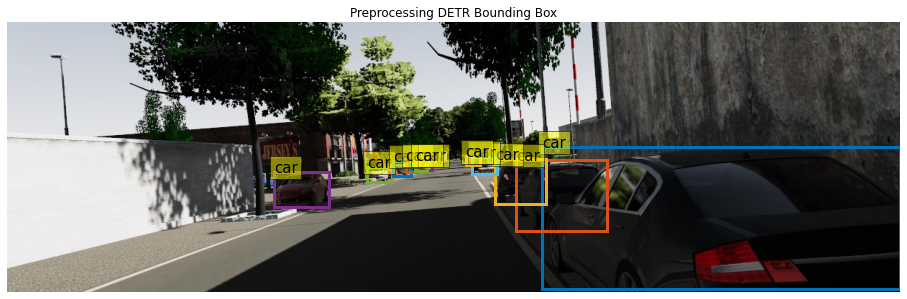

In [33]:
# Preprocessing DETR Result
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p
        text = p
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.title('Preprocessing DETR Bounding Box')
    plt.show()
    
plot_results(img, glp_df['class'], glp_df[['xmin','ymin','xmax','ymax']].values)

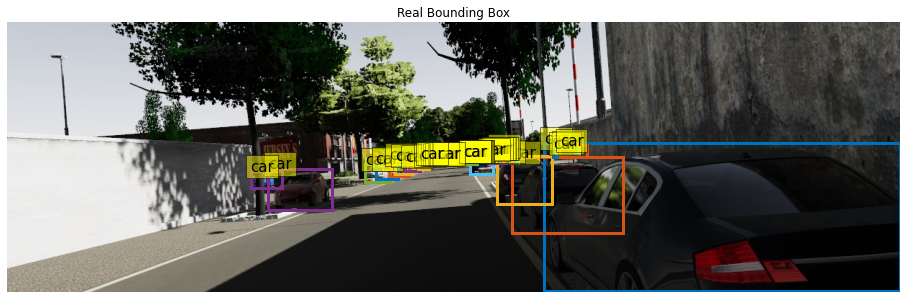

In [34]:
# Real Result
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p
        text = p
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.title('Real Bounding Box')
    plt.show()
    
plot_results(img, df_choose['class'], df_choose[['xmin','ymin','xmax','ymax']].values)